In [1]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
BBOX_PATH = MODEL_PATH+'/bbox'
TEST_IMAGE_PATH = IMAGE_PATH +'/Bilder'

In [2]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 200
GLOBAL_CLIPNORM = 10.0

In [21]:
import numpy as np
import json
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import keras
import keras_cv
from keras.callbacks import EarlyStopping
from keras.preprocessing import image as keras_image
from tensorflow.keras.layers import Dense
from PIL import Image
from keras_cv import visualization
from keras_cv import bounding_box




Using TensorFlow backend


Lade JSON

In [4]:
def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [5]:
JSON_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ JSON_NAME
data = json_read(DATA_PATH)

Bennene Bilder im Verzeichnis images und in der Annotationsdatei um

In [6]:
def rename_images(IMAGE_PATH):
    index=1
    img  = os.listdir(IMAGE_PATH)
    for i in img:
        new_name = f"{index:012d}"+'.jpeg'
        old_path = os.path.join(IMAGE_PATH, i)
        new_path = os.path.join(IMAGE_PATH, new_name)
        os.rename(old_path, new_path)
        index += 1

def rename_images_in_annotation():
    index=1
    for img in data['images']:
        new_name = f"{index:012d}"+'.jpeg'
        img['file_name'] = new_name 
        index += 1

rename_images(IMAGE_PATH+'/original')
rename_images_in_annotation()

with open(ANNOTATION_PATH+'/original' + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)  

In [7]:
images = []
bounding_boxes = []
labels = []
image_height = 1366
image_width = 768

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    box_and_id = []
    one_box.append(annotation['bbox'])
    bounding_boxes.append(one_box)

Resize

In [8]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (width, height))
    cv2.imwrite(output_path, resized_image)    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)
        y = np.round(box[1]*height_ratio,2)
        x_width = np.round(box[2]*width_ratio,2)
        y_height = np.round(box[3]*height_ratio,2)
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


In [9]:
new_height = 640
new_width = 640
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(new_height) + 'x' + str(new_width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(new_height) + 'x' + str(new_width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy JSON Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


In [10]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], new_height, new_width)


with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], new_height, new_width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=new_height
    image['width']=new_width

with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

Create Dataset

In [11]:
images = data['images']
annotations = data['annotations']
categories = data['categories']

dataset = []
dataset_main_labels = []

dataset_sub_labels = []
exklusiv_labels=  list(range(1, 12))
exklusiv_labels.append(25)

for annotation in annotations:
    image_info = next(image for image in images if image['id'] == annotation['image_id'])
    image_path = OUTPUT_PATH_IMAGES + '/'+ image_info['file_name']
    bbox = annotation['bbox']  # [x, y, width, height]
    class_id = annotation['category_id']

    xmin, ymin, width, height = bbox
    #xmax, ymax = xmin + width, ymin + height

    dataset.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, width, height],
        'class_id': class_id
    })
    #main labels
    # (annotation['category_id'] == 1) or
    if (annotation['category_id'] == 11) or (annotation['category_id'] == 25):
        dataset_main_labels.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, width, height],
        'class_id': class_id
        })
    #sub_labels
    #else:
    if (annotation['category_id'] not in exklusiv_labels):
        dataset_sub_labels.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, width, height],
        'class_id': class_id
        })

print('Annotations:',len(dataset))
print(dataset[0])
print(dataset_main_labels)
print(len(dataset_sub_labels))

Annotations: 697
{'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [32.81, 171.74, 401.16, 142.67], 'class_id': 1}
[{'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [29.29, 450.56, 405.32, 65.54], 'class_id': 25}, {'image_path': 'workspace/images/640x640/000000000002.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/640x640/000000000002.jpeg', 'bbox': [29.29, 450.56, 405.32, 65.54], 'class_id': 25}, {'image_path': 'workspace/images/640x640/000000000003.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/640x640/000000000003.jpeg', 'bbox': [29.29, 450.56, 405.32, 65.54], 'class_id': 25}, {'image_path': 'workspace/images/640x640/000000000004.jpeg', 'bbox': [25.04, 313.64, 410.04, 139.01], 'class_id': 11}, {'image_path': 'workspace/images/64

In [12]:
dest_image_dataset = []
dest_image_dataset.append(TEST_IMAGE_PATH+'/Seite1.jpeg')

In [13]:
def get_file_list(directory):
    file_list = []
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)
        normalized_path = os.path.normpath(full_path)
        normalized_path = normalized_path.replace(os.path.sep, '/')
        if os.path.isfile(normalized_path):
            file_list.append(normalized_path)
    return file_list

In [14]:
def create_dataset_arrays(datasets, OUTPUT_PATH_IMAGES):

    directory_path = OUTPUT_PATH_IMAGES
    files = get_file_list(directory_path)
    bbox_list=[]
    class_id_list=[]
    image_list=[]
    image_path_list=[]
    image_path_data=[]
    for k in files:
        ann_bbox=[]
        ann_class_id=[]
        ann_image_path=[]
        for i in datasets:
            d = i
            if i['image_path'] == k:
                ann_bbox.append(d['bbox'])
                ann_class_id.append(d['class_id'])
                ann_image_path=[k]
                
        image = cv2.imread(k)
        image = image / 255.0 
        image_path_data.append(k)
        image_path_list.append(ann_image_path)
        bbox_list.append(ann_bbox)
        class_id_list.append(ann_class_id)
        image_list.append(image)
        

    images_data = np.array(image_list)
    bounding_boxes =   (bbox_list)
    class_labels =  (class_id_list)
    
    return images_data, bounding_boxes, class_labels,image_path_data

In [15]:
#Alle Daten
images_data,bounding_boxes,class_labels,image_path_list=create_dataset_arrays(dataset,OUTPUT_PATH_IMAGES)
#Daten der Main Boxes
main_images_data,main_bounding_boxes,main_class_labels,main_image_path_list=create_dataset_arrays(dataset_main_labels,OUTPUT_PATH_IMAGES)
#Daten der Sub Boxes
sub_images_data,sub_bounding_boxes,sub_class_labels,sub_image_path_list=create_dataset_arrays(dataset_sub_labels,OUTPUT_PATH_IMAGES)

In [16]:
#Main labels umformen von class_id=1,11,25 zu class_id=0,1,2
def forming_main_class_labels(array):
    for i in range(len(array)):
        for j in range(len(array[i])):
            if array[i][j] == 11:
                array[i][j] = 0
            if array[i][j] == 25:
                array[i][j] = 1
    return array
main_class_labels = forming_main_class_labels(main_class_labels)
print((main_class_labels))

sub_class_labels = [[i - 12 for i in sublist] for sublist in sub_class_labels]
print((sub_class_labels))

[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 27, 27], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 16, 18, 19, 20, 21, 22,

In [17]:
#Mappen class_ids für alle Daten
class_ids = []
main_class_ids = []
for d in data['categories']:
    class_name = d['name']
    class_ids.append(class_name)
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Umformen

In [18]:
def create_data_tensor(image_path_list,class_labels,bounding_boxes):
    bounding_boxes_ragged = tf.ragged.constant(bounding_boxes)
    class_labels_ragged = tf.ragged.constant(class_labels)
    image_path_ragged = tf.ragged.constant(image_path_list)

    data_tensor = tf.data.Dataset.from_tensor_slices((image_path_ragged, class_labels_ragged, bounding_boxes_ragged))

    return data_tensor

In [22]:
data_tensor = create_data_tensor(image_path_list,class_labels,bounding_boxes)
main_data_tensor = create_data_tensor(main_image_path_list,main_class_labels,main_bounding_boxes)
sub_data_tensor = create_data_tensor(sub_image_path_list,sub_class_labels,sub_bounding_boxes)

In [23]:
def create_train_test_data(split, data_tensor):
    # Determine the number of validation samples
    num_val = int(split * SPLIT_RATIO)#int(len(image_path_list)

    #Train test split
    val_data = data_tensor.take(num_val)
    train_data = data_tensor.skip(num_val)

    return val_data, train_data

In [24]:
val_data, train_data = create_train_test_data(17, data_tensor)
main_val_data, main_train_data = create_train_test_data(17, main_data_tensor)
sub_val_data, sub_train_data = create_train_test_data(17, sub_data_tensor)

In [25]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path_list, class_labels, bounding_boxes):
    # Read Image
    image = load_image(image_path_list)
    boxes = {
        
        "classes": tf.cast(class_labels, dtype=tf.float32),
        "boxes": bounding_boxes,
    }
    print(boxes)
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": boxes}

In [26]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(new_width, new_height),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xywh",
        ),
    ]
)

In [27]:
def create_train_ds(train_data):
    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 8)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

In [28]:
train_ds = create_train_ds(train_data)
main_train_ds = create_train_ds(main_train_data)
sub_train_ds = create_train_ds(sub_train_data)

{'classes': <tf.Tensor 'Cast:0' shape=(None,) dtype=float32>, 'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))}
{'classes': <tf.Tensor 'Cast:0' shape=(None,) dtype=float32>, 'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))}
{'classes': <tf.Tensor 'Cast:0' shape=(None,) dtype=float32>, 'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))}


In [29]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xywh",
)

def create_val_ds(val_data):
    val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(BATCH_SIZE * 8)
    val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    return val_ds

In [30]:
val_ds = create_train_ds(val_data)
main_val_ds = create_train_ds(main_val_data)
sub_val_ds = create_train_ds(sub_val_data)

{'classes': <tf.Tensor 'Cast:0' shape=(None,) dtype=float32>, 'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))}
{'classes': <tf.Tensor 'Cast:0' shape=(None,) dtype=float32>, 'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))}
{'classes': <tf.Tensor 'Cast:0' shape=(None,) dtype=float32>, 'boxes': tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=float64), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int64))}


In [31]:
for example in train_ds.take(1):
    print(example.keys())
    print("images shape:", example["images"].shape)
    print("bounding_boxes shape:", example["bounding_boxes"]["boxes"].shape)


dict_keys(['images', 'bounding_boxes'])
images shape: (2, 640, 640, 3)
bounding_boxes shape: (2, None, 4)


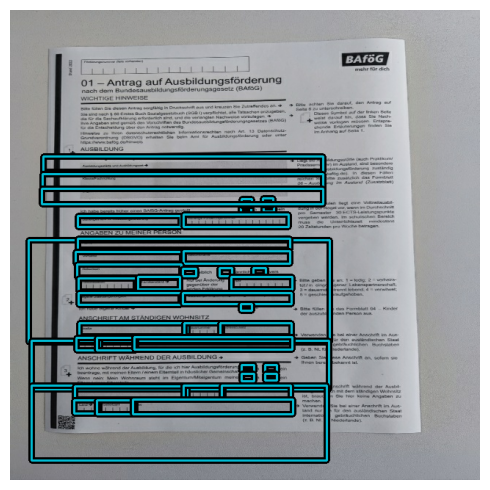

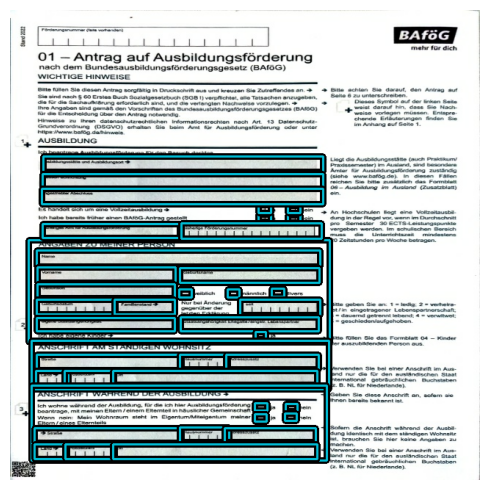

In [32]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
      #  class_mapping=class_mapping,
    )
 
 
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=1, cols=1
)
 
visualize_dataset(
    val_ds, bounding_box_format="xywh", value_range=(0, 255), rows=1, cols=1
)

In [33]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]
 
 
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
 
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

main_train_ds = main_train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
main_train_ds = main_train_ds.prefetch(tf.data.AUTOTUNE)
 
main_val_ds = main_val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
main_val_ds = main_val_ds.prefetch(tf.data.AUTOTUNE)

sub_train_ds = sub_train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
sub_train_ds = sub_train_ds.prefetch(tf.data.AUTOTUNE)
 
sub_val_ds = sub_val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
sub_val_ds = sub_val_ds.prefetch(tf.data.AUTOTUNE)

Yolo xl

In [34]:
"""
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
            classification_loss="binary_crossentropy", 
            box_loss="ciou",#Complete IoU, Overlap ground truth and predicted
            optimizer=tf.optimizers.SGD(global_clipnorm=10.0),
            )
yolo.summary()
"""

'\nyolo = keras_cv.models.YOLOV8Detector(\n    num_classes=len(class_mapping),\n    bounding_box_format="xywh",\n    backbone=backbone,\n    fpn_depth=1,\n)\noptimizer = tf.keras.optimizers.Adam(\n    learning_rate=LEARNING_RATE,\n    global_clipnorm=GLOBAL_CLIPNORM,\n)\n\nyolo.compile(\n            classification_loss="binary_crossentropy", \n            box_loss="ciou",#Complete IoU, Overlap ground truth and predicted\n            optimizer=tf.optimizers.SGD(global_clipnorm=10.0),\n            )\nyolo.summary()\n'

In [40]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xl_backbone_coco", #xs=1.28M Parameter, pretrained mit coco
    input_shape=(new_width, new_height, 3),
)

yolov8_xl_v1 = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolov8_xl_v1.compile(
            classification_loss=keras.losses.BinaryCrossentropy(from_logits=True), 
            box_loss=keras.losses.MeanSquaredError(
                    reduction="sum_over_batch_size", name="mean_squared_error"),
            optimizer=tf.optimizers.SGD(global_clipnorm=10.0),)



In [43]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

history = yolov8_xl_v1.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

SyntaxError: keyword argument repeated: callbacks (213552696.py, line 12)

In [42]:
SAVED_MODEL_PATH = BBOX_PATH+'/yolov8_xl_v1_pretrained.h5'
model = yolov8_xl_v1
#model.save_weights(SAVED_MODEL_PATH)

In [ ]:
model.load_weights(SAVED_MODEL_PATH)

In [50]:
#Metrics
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            evaluate_freq=1e9,
        )
 
        self.save_path = save_path
        self.best_map = -1.0
 
    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)
 
        metrics = self.metrics.result(force=True)
        logs.update(metrics)
 
        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves
 
        return logs
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

YOLO l

In [51]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco", #19.83M
    input_shape=(new_width, new_height, 3),
)

yolov8_l_v1= keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
    
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,    
                                  
)
yolov8_l_v1.compile(
            classification_loss='binary_crossentropy',#keras.losses.CategoricalCrossentropy(),#'binary_crossentropy', 
            box_loss='ciou',# Complete IoU (CIoU)
            optimizer=optimizer,)


In [57]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

history = yolov8_l_v1.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/200
7/7 [==============================] - 57s 4s/step - loss: 81.7209 - box_loss: 5.4218 - class_loss: 76.2991 - val_loss: 507.6942 - val_box_loss: 3.8453 - val_class_loss: 503.8489
Epoch 2/200
7/7 [==============================] - 22s 3s/step - loss: 33.4698 - box_loss: 4.1402 - class_loss: 29.3296 - val_loss: 2302.0122 - val_box_loss: 1.4100 - val_class_loss: 2300.6021
Epoch 3/200
7/7 [==============================] - 24s 3s/step - loss: 22.0397 - box_loss: 3.7320 - class_loss: 18.3077 - val_loss: 50.8308 - val_box_loss: 0.0000e+00 - val_class_loss: 50.8308
Epoch 4/200
7/7 [==============================] - 22s 3s/step - loss: 14.7819 - box_loss: 3.3524 - class_loss: 11.4294 - val_loss: 6.5354 - val_box_loss: 0.0000e+00 - val_class_loss: 6.5354
Epoch 5/200
7/7 [==============================] - 22s 3s/step - loss: 10.5566 - box_loss: 3.0624 - class_loss: 7.4942 - val_loss: 18.2751 - val_box_loss: 0.0000e+00 - val_class_loss: 18.2751
Epoch 6/200
7/7 [=======================

KeyboardInterrupt: 

In [52]:
SAVED_MODEL_PATH = BBOX_PATH+'/yolov8_l_v1_pretrained.h5'
model = yolov8_l_v1
model.save_weights(SAVED_MODEL_PATH)

In [53]:
#model.save_weights(SAVED_MODEL_PATH)

In [54]:
model.load_weights(SAVED_MODEL_PATH)

1/1 [==============================] - 1s 912ms/step


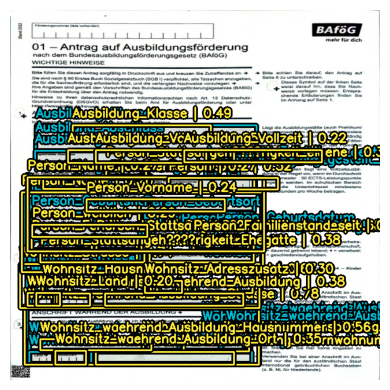

In [62]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images, batch_size=BATCH_SIZE)
    y_predictions = model.predict(images, batch_size=BATCH_SIZE)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )
    return y_predictions

y_pred = visualize_detections(yolov8_l_v1, dataset=val_ds, bounding_box_format="xywh")

In [66]:
def extract_boxes(predictions_on_image):
    best_bboxes = {}
    class_id = []
    bbox = []
    confidence = []

    for i in range(0, predictions_on_image['num_detections'][0]):
        class_id.append(predictions_on_image['classes'][0][i])
        bbox.append(predictions_on_image['boxes'][0][i])
        confidence.append(predictions_on_image['confidence'][0][i])

    for i in range(len(class_id)):
        current_class = class_id[i]
        current_confidence = confidence[i]
        current_box = bbox[i]

        if current_class in best_bboxes and np.all(current_box > best_bboxes[current_class]):
            best_bboxes[current_class] = current_box
        elif current_class not in best_bboxes:
            best_bboxes[current_class] = current_box

    return best_bboxes


best_bboxes = extract_boxes(y_pred)

predicted_class_ids = list(best_bboxes.keys())
predicted_bounding_boxes = list(best_bboxes.values())
predicted_ids_names = []

for id in predicted_class_ids:
    predicted_ids_names.append(class_mapping[id])

print("predicted_class_ids:", predicted_ids_names)
print("predicted_bounding_boxes:", predicted_bounding_boxes)

predicted_class_ids: ['Wohnsitz_waehrend_Ausbildung_Strasse', 'Wohnsitz_Strasse', 'Person_Familienstand', 'Person_Name', 'Wohnsitz_waehrend_Ausbildung_Adresszusatz', 'Wohnsitz_waehrend_Ausbildung_Land', 'Person_StattsangehÃ¶rigkeit_eigene', 'Wohnsitz_Land', 'Wohnsitz_Hausnummer', 'Wohnsitz_waehrend_Ausbildung_elternwohnung_ja', 'Person_Familienstand_seit', 'Wohnsitz_waehrend_Ausbildung_Hausnummer', 'Ausbildung_Foerderungsnummer', 'Ausbildung_Klasse', 'Person_Kinder', 'Wohnsitz_Ort', 'Wohnsitz_waehrend_Ausbildung', 'Person_StattsangehÃ¶rigkeit_Ehegatte', 'Person', 'Wohnsitz_waehrend_Ausbildung_Ort', 'Wohnsitz_Adresszusatz', 'Person_weiblich', 'Ausbildung_Vollzeit', 'Person_Vorname']
predicted_bounding_boxes: [array([ 25.739868, 511.74255 , 404.99426 , 102.07196 ], dtype=float32), array([ 17.7034 , 439.9762 , 413.5817 ,  75.62012], dtype=float32), array([ 37.583992, 393.8913  , 103.518654,  20.233826], dtype=float32), array([ 20.534943, 315.03668 , 416.64023 , 138.24292 ], dtype=float32)

In [41]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['box_loss'], label='Box Loss')
    plt.plot(history.history['class_loss'], label='Class Loss')
    plt.title('Box and Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

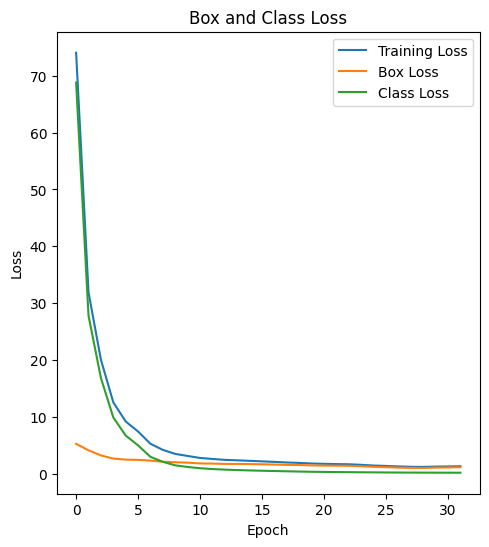

In [42]:
plot_metrics(history)

In [43]:
def predict_at_image(model, image_path):
    img = keras_image.load_img(image_path, target_size=(new_height, new_width))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_classes =np.array(predictions['classes'])
    predicted_boxes =np.array(predictions['boxes'])
    predicted_confidence = np.array(predictions['confidence'])

    return predicted_classes,predicted_boxes,predicted_confidence

In [44]:
def plot_bounding_boxes(boxes, image_path):
    img = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    plt.show()

In [45]:
def plot_image(image_path):
    image = plt.imread(image_path)
    plt.imshow(image)

In [46]:
def predict_on_images(model, i, k):

    image_to_preict = OUTPUT_PATH_IMAGES + '/00000000000'+str(i)+'.jpeg'

    predictions= predict_at_image(model,image_to_preict)
    predicted_boxes_array = predictions[1].reshape(-1, 4)
    sliced_array = predicted_boxes_array[:10]
    plot_bounding_boxes(sliced_array, image_to_preict)
    predictions={
        "class_id" :predictions[0],
        "bboxes":predictions[1],
        "confidence":predictions[2] 

        }
    print(predictions)
    return predictions


Yolo Main Labels

In [48]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco", #
    input_shape=(new_width, new_height, 3),
)

yolov8_xs_main_labbels = keras_cv.models.YOLOV8Detector(
    num_classes=5,#len(main_class_labels[1]),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
    
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM, 
                              
)
yolov8_xs_main_labbels.compile(
            #classification_loss=keras.losses.BinaryCrossentropy(
             #                   from_logits=False,
              #                  label_smoothing=0.0,
               #                 axis=-1,
                #                reduction="sum_over_batch_size",
                 #              name="binary_crossentropy",), 
            #box_loss=keras.losses.MeanSquaredError(
            #        reduction="sum_over_batch_size", name="mean_squared_error"),
            classification_loss='binary_crossentropy',#keras.losses.CategoricalCrossentropy(),#'binary_crossentropy', 
            box_loss='ciou',
            optimizer=optimizer,)
#yolov8_xs_main_labbels_.summary()


In [49]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

history_main_labels = yolov8_xs_main_labbels.fit(
    main_train_ds, 
    validation_data=main_val_ds,
    epochs=EPOCH,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/200
7/7 [==============================] - 30s 906ms/step - loss: 525.0953 - box_loss: 4.2345 - class_loss: 520.8608 - val_loss: 448.1281 - val_box_loss: 4.8538 - val_class_loss: 443.2742
Epoch 2/200
7/7 [==============================] - 3s 422ms/step - loss: 232.8803 - box_loss: 2.3035 - class_loss: 230.5768 - val_loss: 420.4549 - val_box_loss: 4.7893 - val_class_loss: 415.6656
Epoch 3/200
7/7 [==============================] - 3s 419ms/step - loss: 185.8361 - box_loss: 2.1278 - class_loss: 183.7083 - val_loss: 370.0142 - val_box_loss: 4.3806 - val_class_loss: 365.6335
Epoch 4/200
7/7 [==============================] - 3s 434ms/step - loss: 181.0007 - box_loss: 2.3634 - class_loss: 178.6373 - val_loss: 286.8889 - val_box_loss: 3.5629 - val_class_loss: 283.3260
Epoch 5/200
7/7 [==============================] - 3s 412ms/step - loss: 157.9776 - box_loss: 2.1582 - class_loss: 155.8193 - val_loss: 179.7680 - val_box_loss: 2.3949 - val_class_loss: 177.3731
Epoch 6/200
7/7 [=======

In [50]:

image_path = OUTPUT_PATH_IMAGES + '/000000000003.jpeg'
image = cv2.imread(image_path)
#image = cv2.resize(image, (416, 416))  # Achte darauf, die Größe entsprechend den Modellanforderungen anzupassen
image = np.expand_dims(image, axis=0)  # Hinzufügen der Batch-Dimension


# Führe die Vorhersage durch
predictions = yolov8_xs_main_labbels.predict(image)
main_predictions = yolov8_xs_main_labbels.predict(image)
print(main_predictions)

1/1 [==============================] - 0s 184ms/step
{'boxes': array([[[ 11.655365, 313.7897  , 409.13266 , 139.03052 ],
        [108.00064 , 450.5182  , 239.99509 ,  65.587036],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [

In [51]:
#model = yolov8_xs_main_labbels
model.get_config() 

{'num_classes': 5,
 'bounding_box_format': 'xywh',
 'fpn_depth': 1,
 'backbone': {'module': 'keras_cv.src.models.object_detection.yolo_v8.yolo_v8_backbone',
  'class_name': 'YOLOV8Backbone',
  'config': {'name': 'yolov8_backbone_2',
   'trainable': True,
   'include_rescaling': True,
   'input_shape': (640, 640, 3),
   'stackwise_channels': [32, 64, 128, 256],
   'stackwise_depth': [1, 2, 2, 1],
   'activation': 'swish'},
  'registered_name': 'keras_cv>YOLOV8Backbone',
  'build_config': {'input_shape': (None, 640, 640, 3)}},
 'label_encoder': <keras_cv.src.models.object_detection.yolo_v8.yolo_v8_label_encoder.YOLOV8LabelEncoder at 0x2246c8b2390>,
 'prediction_decoder': <keras_cv.src.layers.object_detection.non_max_suppression.NonMaxSuppression at 0x2246c899550>}

Ausschnitt der Main Boxes 

Transfer Learning